In [1]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress')

In [2]:
!pwd

/Users/evanli/Documents/EvanPys/Progress


In [3]:
from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
import scanpy as sc
import scvelo as scv

# data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')
data = scv.datasets.pancreas(file_path='/home/evanlee/Pancreas_AD2/endocrinogenesis_day15.h5ad')
label = data.obs['clusters'].tolist()
# Log normalize
sc.pp.log1p(data)

In [4]:
data.shape

(3696, 27998)

In [5]:
celltype = 'Alpha'
fdf = pd.read_csv(f'./Pancreas_result/result_v3/{celltype}_features.txt', sep='\t', header=None, names=['Gene', 'Weight', 'Tendency'])
fdf

,Gene,Weight,Tendency
0,Ptma,-0.562290,0
1,Pyy,0.068511,1
2,H3f3b,-0.131253,0
3,Gcg,0.406925,1
4,Rplp0,-0.243363,0
5,Ftl1,-0.110125,0
6,Rps9,-0.100350,0
7,Rps19,-0.046946,0
8,Tmem27,0.729405,1


In [6]:
fdf.shape

(9, 3)

## Read in the ADlasso features from 8 cell types

In [7]:
types = np.unique(label).tolist()
types = sorted(types)

all_features = {}
positive_features = {}
for celltype in types:
    print('Reading:', celltype)
    # all features (including positive and negative)
    features_df = pd.read_csv(f'./Pancreas_result/result_v3/{celltype}_features.txt', sep='\t', header=None, names=['Gene', 'Weight', 'Tendency'])
    all_features[celltype] = features_df['Gene'].tolist()
    # positive features
    positive_features_df = features_df[features_df['Tendency'] == 1]
    positive_features[celltype] = positive_features_df['Gene'].tolist()


Reading: Alpha
Reading: Beta
Reading: Delta
Reading: Ductal
Reading: Epsilon
Reading: Ngn3 high EP
Reading: Ngn3 low EP
Reading: Pre-endocrine


In [8]:
for celltype in all_features.keys():
    print(celltype, len(all_features[celltype]))
print('=====')
for celltype in positive_features.keys():
    print(celltype, len(positive_features[celltype]))

Alpha 9
Beta 22
Delta 22
Ductal 28
Epsilon 6
Ngn3 high EP 14
Ngn3 low EP 4
Pre-endocrine 47
=====
Alpha 3
Beta 12
Delta 0
Ductal 16
Epsilon 1
Ngn3 high EP 5
Ngn3 low EP 0
Pre-endocrine 22


In [9]:
# add the features from 8 cell types into a single list
all_features_list = [g for g_celltype in all_features.values() for g in g_celltype]
positive_features_list = [g for g_celltype in positive_features.values() for g in g_celltype]
print(len(all_features_list))
print(len(positive_features_list))

152
59


## Plot Leiden UMAP with HVG2000

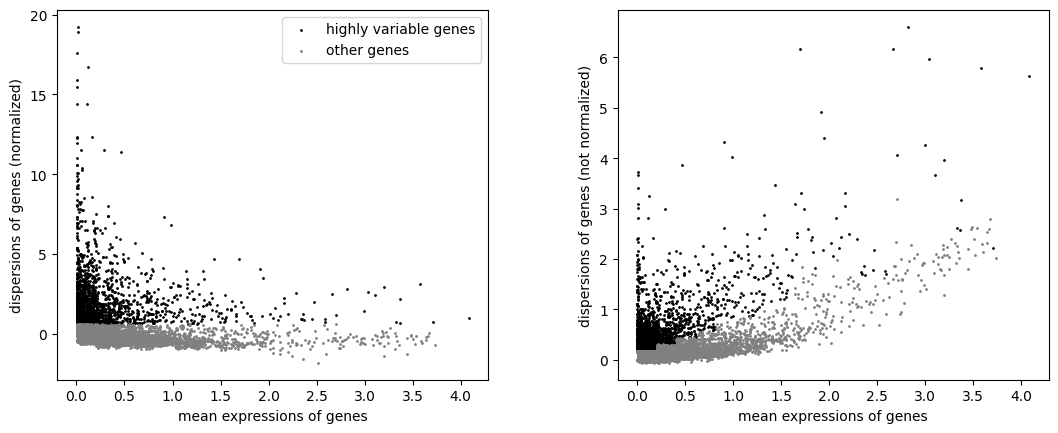

In [12]:
# select HVG2000 (from original 27998 genes)
sc.pp.highly_variable_genes(data, n_top_genes=2000)
sc.pl.highly_variable_genes(data)


In [13]:
# 2000 HVGs
sum(data.var['highly_variable'])

2000

In [14]:
# filtering the non-Highly variable genes in data
data_HVG = data[:, data.var.highly_variable]  # choose columns, Genes
data_HVG.shape  # (3696, 2000)

(3696, 2000)

In [16]:
data_HVG.obs

,clusters_coarse,clusters,S_score,G2M_score
index,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030
...,...,...,...,...
TTTGTCAAGTGACATA,Pre-endocrine,Pre-endocrine,-0.235896,-0.266101
TTTGTCAAGTGTGGCA,Ngn3 high EP,Ngn3 high EP,0.279374,-0.204047
TTTGTCAGTTGTTTGG,Ductal,Ductal,-0.045692,-0.208907


In [17]:
# PCA
sc.tl.pca(data_HVG, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(data_HVG, n_neighbors=15)

# kNN
# sc.external.pp.bbknn(data_HVG)

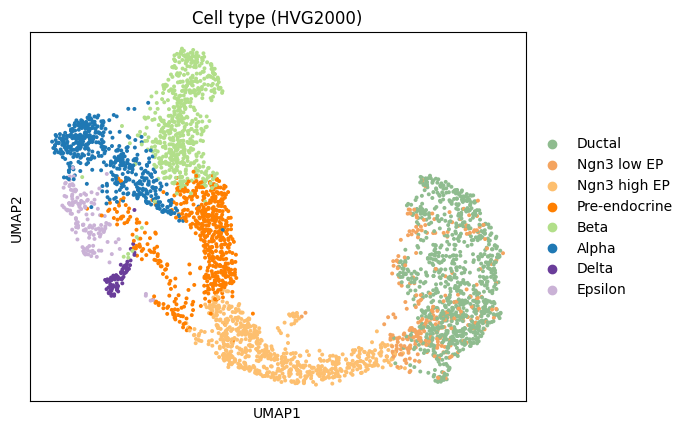

In [18]:
# UMAP
sc.tl.umap(data_HVG)
sc.pl.umap(data_HVG, color='clusters', title='Cell type (HVG2000)')

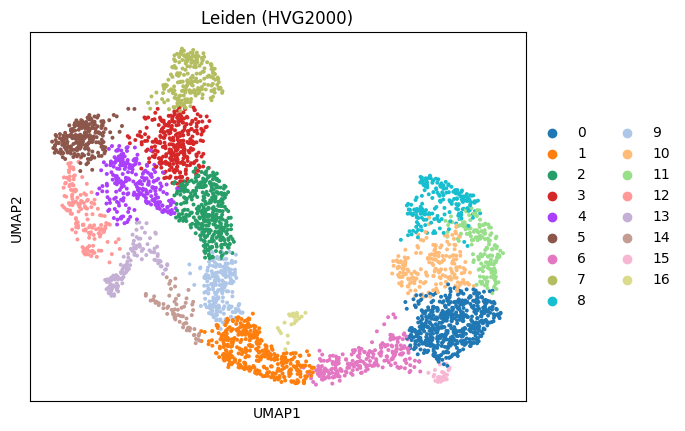

In [19]:
# Leiden clustering
sc.tl.leiden(data_HVG)

# Plot Leiden UMAP
sc.pl.umap(data_HVG, color='leiden', title='Leiden (HVG2000)')

## Plot Leiden UMAP with all ADlasso features

In [35]:
data_all_features = data[:, all_features_list]
data_all_features.shape

(3696, 152)

In [36]:
# PCA
sc.tl.pca(data_all_features, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(data_all_features, n_neighbors=15)

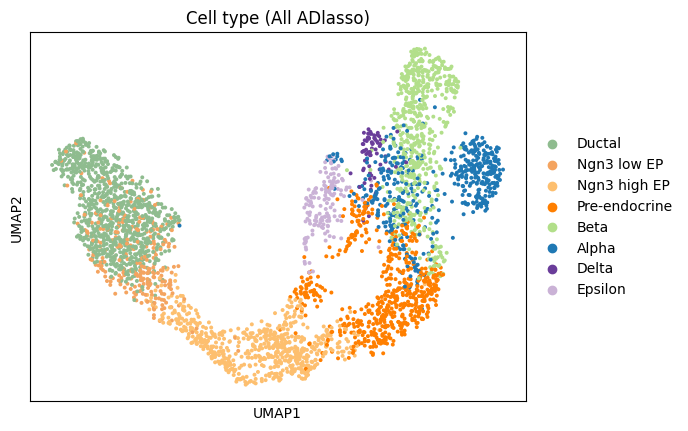

In [37]:
# UMAP
sc.tl.umap(data_all_features)
sc.pl.umap(data_all_features, color='clusters', title='Cell type (All ADlasso)')

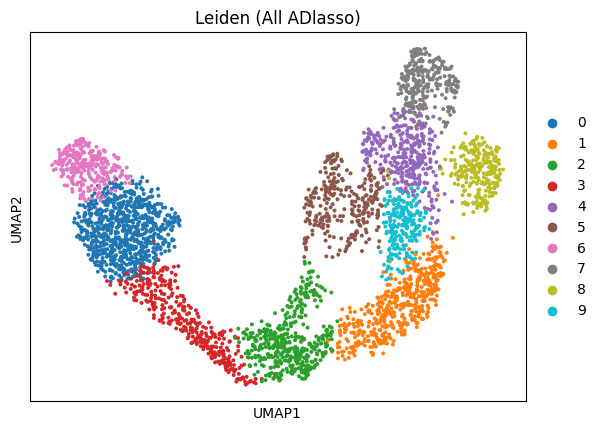

In [38]:
# Leiden clustering
sc.tl.leiden(data_all_features)

# Plot Leiden UMAP
sc.pl.umap(data_all_features, color='leiden', title='Leiden (All ADlasso)')

## Plot Leiden UMAP with positive ADlasso features

In [28]:
data_positive = data[:, positive_features_list]
data_positive.shape

(3696, 59)

In [30]:
# PCA
sc.tl.pca(data_positive, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(data_positive, n_neighbors=15)

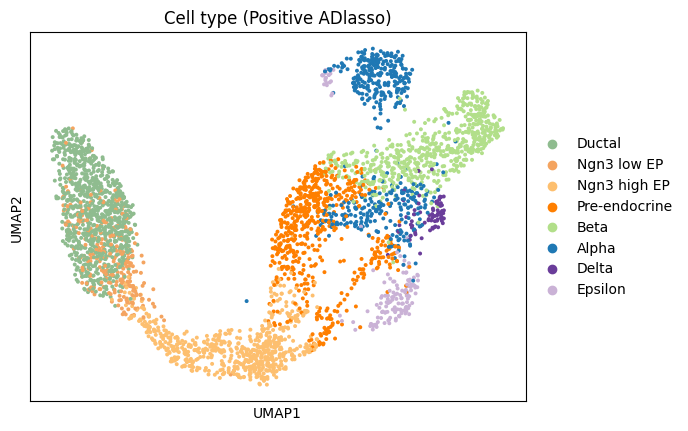

In [31]:
# UMAP
sc.tl.umap(data_positive)
sc.pl.umap(data_positive, color='clusters', title='Cell type (Positive ADlasso)')

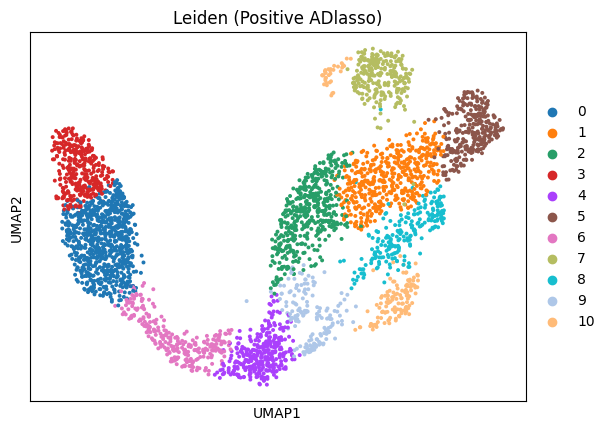

In [32]:
# Leiden clustering
sc.tl.leiden(data_positive)

# Plot Leiden UMAP
sc.pl.umap(data_positive, color='leiden', title='Leiden (Positive ADlasso)')

## Evaluate ARI

In [22]:
import sklearn
from sklearn.metrics.cluster import adjusted_rand_score



In [34]:
celltypes = np.unique(label)
type2num = {ct: idx for idx, ct in enumerate(celltypes)}

In [35]:
type2num

{'Alpha': 0,
 'Beta': 1,
 'Delta': 2,
 'Ductal': 3,
 'Epsilon': 4,
 'Ngn3 high EP': 5,
 'Ngn3 low EP': 6,
 'Pre-endocrine': 7}

In [36]:
# ARI for HVG2000: Leiden vs. Actual celltype
labels_true = [type2num[ct] for ct in label]
labels_pred = data_HVG.obs['leiden'].tolist()
adjusted_rand_score(labels_true, labels_pred)

0.4355415335576269

In [37]:
# ARI for all ADlasso features
labels_true = [type2num[ct] for ct in label]
labels_pred = data_all_features.obs['leiden'].tolist()
adjusted_rand_score(labels_true, labels_pred)

0.48079548021359003

In [38]:
# ARI for all ADlasso features
labels_true = [type2num[ct] for ct in label]
labels_pred = data_positive.obs['leiden'].tolist()
adjusted_rand_score(labels_true, labels_pred)

0.47974809811635366

## ARI & NMI (Leiden vs. cell label (one vs. rest))
examine the specificity of marker gene from ADLasso2 with clusting performace in each cell type

### Try: celltype Alpha

In [20]:
# Alpha vs. rest (HVG2000)
hvg_true = [1 if x == 'Alpha' else 0 for x in label]
hvg_pred = data_HVG.obs['leiden'].tolist()  # 17 leiden clusters for HVG2000

In [23]:
adjusted_rand_score(hvg_true, hvg_pred)

0.04184116652077732

In [24]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(hvg_true, hvg_pred)

0.2079661726599465

In [39]:
# Alpha vs. rest (all features)
all_features_true = [1 if x == 'Alpha' else 0 for x in label]
all_features_pred = data_all_features.obs['leiden'].tolist()  # 10 leiden clusters for all features
adjusted_rand_score(all_features_true, all_features_pred)

0.051382346988808746

In [40]:
normalized_mutual_info_score(all_features_true, all_features_pred)

0.1730441275229456

In [26]:
# all Alpha features
all_features['Alpha']

['Ptma', 'Pyy', 'H3f3b', 'Gcg', 'Rplp0', 'Ftl1', 'Rps9', 'Rps19', 'Tmem27']

(3696, 9)


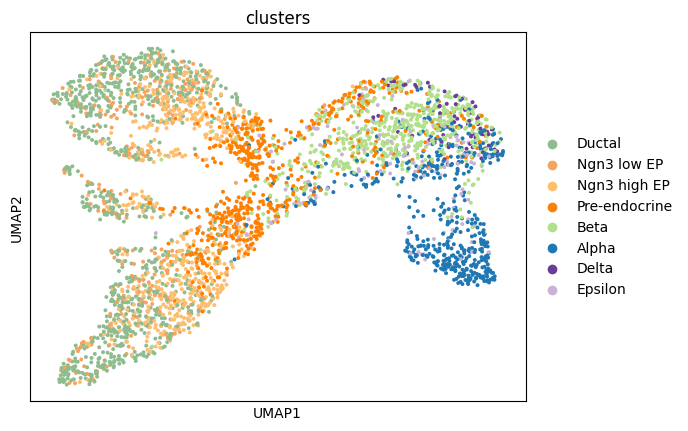

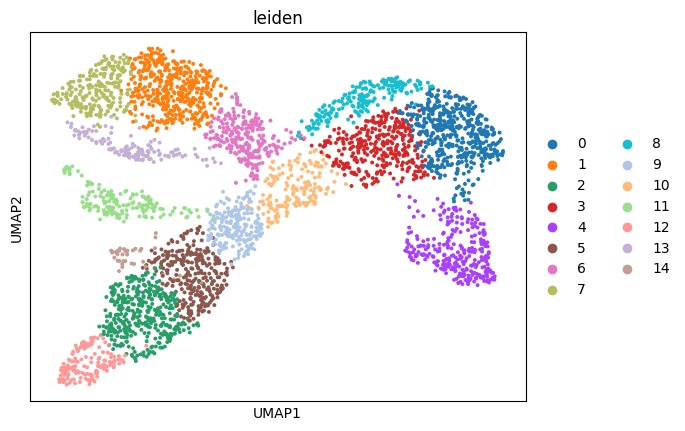

In [44]:
# Alpha vs. rest (all Alpha features)
data_alpha_features = data[:, all_features['Alpha']]
print(data_alpha_features.shape)

# PCA
sc.tl.pca(data_alpha_features, svd_solver='arpack')
# Neighborhood graph
sc.pp.neighbors(data_alpha_features, n_neighbors=15)
# UMAP
sc.tl.umap(data_alpha_features)
sc.pl.umap(data_alpha_features, color='clusters')

# Leiden
sc.tl.leiden(data_alpha_features)
# Leiden UMAP
sc.pl.umap(data_alpha_features, color='leiden')

In [45]:
alpha_features_true = [1 if x == 'Alpha' else 0 for x in label]
alpha_features_pred = data_alpha_features.obs['leiden'].tolist()  # 10 leiden clusters for all features
adjusted_rand_score(alpha_features_true, alpha_features_pred)

0.02113170956006252

In [46]:
normalized_mutual_info_score(alpha_features_true, alpha_features_pred)

0.14536876494021583

### Test all celltypes one by one

In [76]:
HVG_performance = pd.DataFrame(columns=['ARI', 'NMI'])
all_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])
positive_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])

for celltype in types:
    # HVG2000
    hvg_true = [1 if x == celltype else 0 for x in label]
    hvg_pred = data_HVG.obs['leiden'].tolist()
    ari = adjusted_rand_score(hvg_true, hvg_pred)
    nmi = normalized_mutual_info_score(hvg_true, hvg_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    HVG_performance = pd.concat([HVG_performance, new_row])

    # all features
    all_features_true = [1 if x == celltype else 0 for x in label]
    all_features_pred = data_all_features.obs['leiden'].tolist()
    ari = adjusted_rand_score(all_features_true, all_features_pred)
    nmi = normalized_mutual_info_score(all_features_true, all_features_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    all_features_performance = pd.concat([all_features_performance, new_row])
    
    # positive features
    positive_features_true = [1 if x == celltype else 0 for x in label]
    positive_features_pred = data_positive.obs['leiden'].tolist()
    ari = adjusted_rand_score(positive_features_true, all_features_pred)
    nmi = normalized_mutual_info_score(positive_features_true, positive_features_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    positive_features_performance = pd.concat([positive_features_performance, new_row])

In [61]:
HVG_performance

,ARI,NMI
Alpha,0.041841,0.207966
Beta,0.052072,0.238704
Delta,0.005321,0.050803
Ductal,0.064400,0.252886
Epsilon,0.012302,0.098234
Ngn3 high EP,0.058059,0.243210
Ngn3 low EP,-0.001073,0.053966
Pre-endocrine,0.044705,0.191743


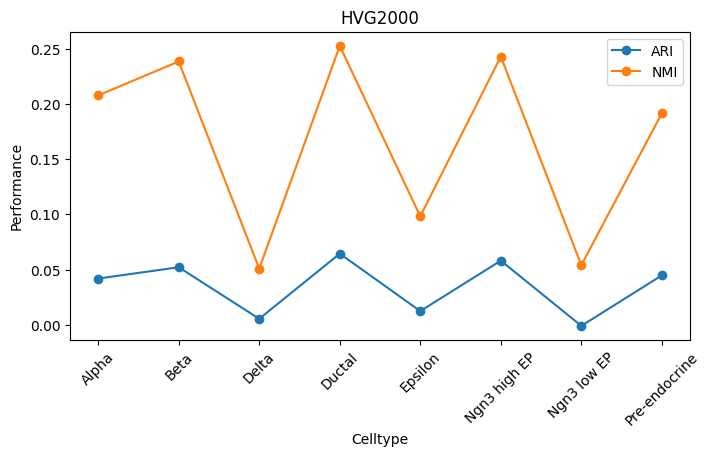

In [74]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(HVG_performance.index, HVG_performance['ARI'], label='ARI', marker='o')
ax.plot(HVG_performance.index, HVG_performance['NMI'], label='NMI', marker='o')
ax.set_xlabel('Celltype')
ax.set_ylabel('Performance')
ax.set_title('HVG2000')
ax.set_xticklabels(HVG_performance.index, rotation=45)
ax.legend()
plt.show()

In [62]:
all_features_performance

,ARI,NMI
Alpha,0.051382,0.173044
Beta,0.067966,0.218690
Delta,0.003434,0.032411
Ductal,0.096360,0.303674
Epsilon,0.013139,0.085886
Ngn3 high EP,0.071478,0.237405
Ngn3 low EP,-0.006091,0.065631
Pre-endocrine,0.057182,0.186816


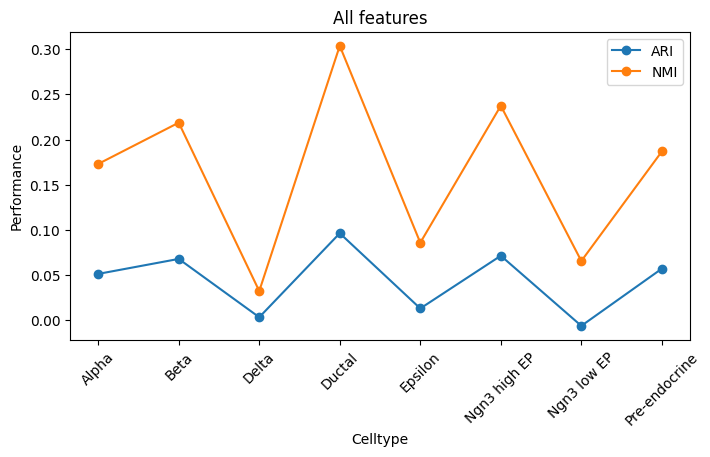

In [75]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_features_performance.index, all_features_performance['ARI'], label='ARI', marker='o')
ax.plot(all_features_performance.index, all_features_performance['NMI'], label='NMI', marker='o')
ax.set_xlabel('Celltype')
ax.set_ylabel('Performance')
ax.set_title('All features')
ax.set_xticklabels(all_features_performance.index, rotation=45)
ax.legend()
plt.show()

In [77]:
positive_features_performance

,ARI,NMI
Alpha,0.051382,0.168167
Beta,0.067966,0.222457
Delta,0.003434,0.042891
Ductal,0.096360,0.290515
Epsilon,0.013139,0.107713
Ngn3 high EP,0.071478,0.268799
Ngn3 low EP,-0.006091,0.064254
Pre-endocrine,0.057182,0.191207


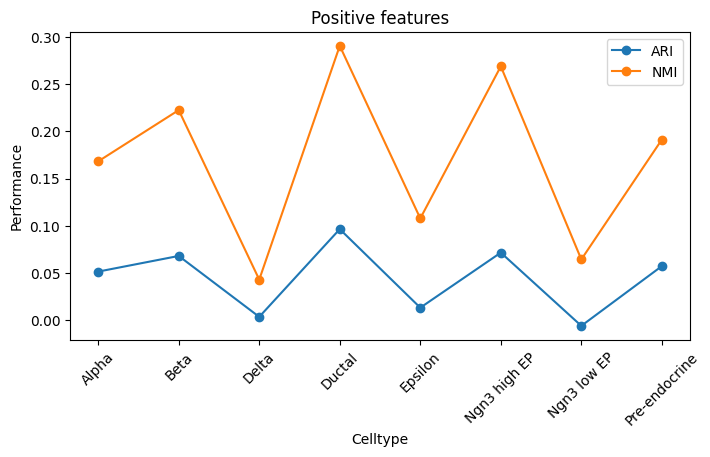

In [78]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(positive_features_performance.index, positive_features_performance['ARI'], label='ARI', marker='o')
ax.plot(positive_features_performance.index, positive_features_performance['NMI'], label='NMI', marker='o')
ax.set_xlabel('Celltype')
ax.set_ylabel('Performance')
ax.set_title('Positive features')
ax.set_xticklabels(positive_features_performance.index, rotation=45)
ax.legend()
plt.show()

### Test all celltypes one by one (modified to use only the features from the celltype that we're testing)

In [49]:
HVG_performance = pd.DataFrame(columns=['ARI', 'NMI'])
# celltype_features_performance
all_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])
# positive_features_performance = pd.DataFrame(columns=['ARI', 'NMI'])

for celltype in types:
    # celltype vs. Rest (HVG2000)
    hvg_true = [1 if x == celltype else 0 for x in label]
    hvg_pred = data_HVG.obs['leiden'].tolist()
    ari = adjusted_rand_score(hvg_true, hvg_pred)
    nmi = normalized_mutual_info_score(hvg_true, hvg_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    HVG_performance = pd.concat([HVG_performance, new_row])

    # celltype vs. Rest (celltype's features)
    data_celltype_features = data[:, all_features[celltype]]
    # PCA
    sc.tl.pca(data_celltype_features, svd_solver='arpack')
    # Neighborhood graph
    sc.pp.neighbors(data_celltype_features, n_neighbors=15)
    # UMAP
    sc.tl.umap(data_celltype_features)
#     sc.pl.umap(data_alpha_features, color='clusters')
    # Leiden
    sc.tl.leiden(data_celltype_features)
    # Leiden UMAP
#     sc.pl.umap(data_alpha_features, color='leiden')
    features_true = [1 if x == celltype else 0 for x in label]
    features_pred = data_celltype_features.obs['leiden'].tolist()
    ari = adjusted_rand_score(features_true, features_pred)
    nmi = normalized_mutual_info_score(features_true, features_pred)
    new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
    all_features_performance = pd.concat([all_features_performance, new_row])
    
#     # positive features
#     positive_features_true = [1 if x == celltype else 0 for x in label]
#     positive_features_pred = data_positive.obs['leiden'].tolist()
#     ari = adjusted_rand_score(positive_features_true, all_features_pred)
#     nmi = normalized_mutual_info_score(positive_features_true, positive_features_pred)
#     new_row = pd.DataFrame({'ARI': ari, 'NMI': nmi}, index=[celltype])
#     positive_features_performance = pd.concat([positive_features_performance, new_row])

In [50]:
HVG_performance

,ARI,NMI
Alpha,0.041841,0.207966
Beta,0.052072,0.238704
Delta,0.005321,0.050803
Ductal,0.064400,0.252886
Epsilon,0.012302,0.098234
Ngn3 high EP,0.058059,0.243210
Ngn3 low EP,-0.001073,0.053966
Pre-endocrine,0.044705,0.191743


In [51]:
all_features_performance

,ARI,NMI
Alpha,0.021132,0.145369
Beta,0.068150,0.246359
Delta,-0.003234,0.013192
Ductal,0.153379,0.332440
Epsilon,0.010905,0.094237
Ngn3 high EP,0.107414,0.286602
Ngn3 low EP,0.000777,0.035740
Pre-endocrine,0.066815,0.189338


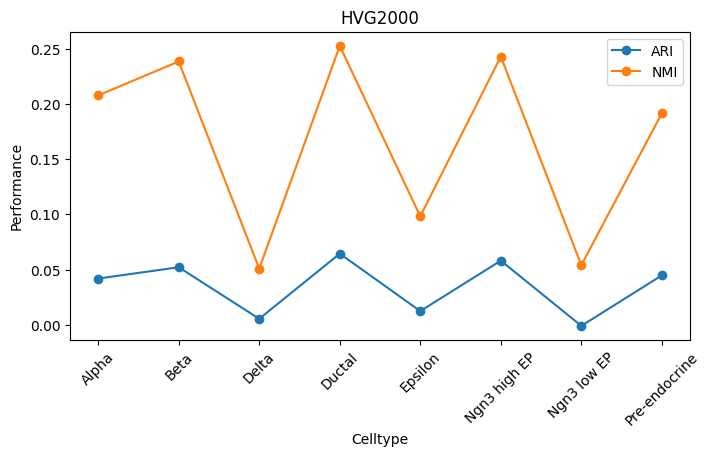

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(HVG_performance.index, HVG_performance['ARI'], label='ARI', marker='o')
ax.plot(HVG_performance.index, HVG_performance['NMI'], label='NMI', marker='o')
ax.set_xlabel('Celltype')
ax.set_ylabel('Performance')
ax.set_title('HVG2000')
ax.set_xticklabels(HVG_performance.index, rotation=45)
ax.legend()
plt.show()

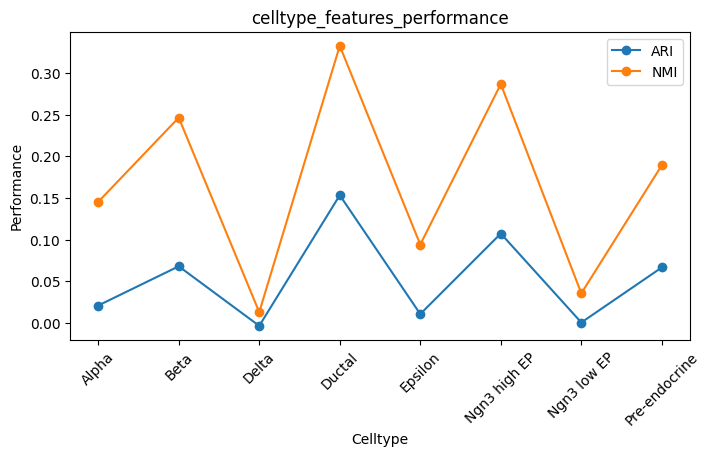

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_features_performance.index, all_features_performance['ARI'], label='ARI', marker='o')
ax.plot(all_features_performance.index, all_features_performance['NMI'], label='NMI', marker='o')
ax.set_xlabel('Celltype')
ax.set_ylabel('Performance')
ax.set_title('celltype_features_performance')
ax.set_xticklabels(HVG_performance.index, rotation=45)
ax.legend()
plt.show()

### Test all celltypes one by one (Re-plot)
Modified to use only the features from the celltype that we're testing

In [4]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Pancreas_ADlasso/Pancreas_result')

In [5]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/Pancreas_ADlasso/Pancreas_result


In [15]:
import pandas as pd

In [12]:
import html5lib

HVG_performance = pd.read_html('ARI4_HVG_performance.html', index_col=0)[0]

In [13]:
HVG_performance

,ARI,NMI
Alpha,0.041841,0.207966
Beta,0.052072,0.238704
Delta,0.005321,0.050803
Ductal,0.064400,0.252886
Epsilon,0.012302,0.098234
Ngn3 high EP,0.058059,0.243210
Ngn3 low EP,-0.001073,0.053966
Pre-endocrine,0.044705,0.191743


In [14]:
all_features_performance = pd.read_html('ARI4_all_features_performance.html', index_col=0)[0]

In [15]:
all_features_performance

,ARI,NMI
Alpha,0.021132,0.145369
Beta,0.068150,0.246359
Delta,-0.003234,0.013192
Ductal,0.153379,0.332440
Epsilon,0.010905,0.094237
Ngn3 high EP,0.107414,0.286602
Ngn3 low EP,0.000777,0.035740
Pre-endocrine,0.066815,0.189338


In [16]:
HVG_performance.index

Index(['Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon', 'Ngn3 high EP',
       'Ngn3 low EP', 'Pre-endocrine'],
      dtype='object')

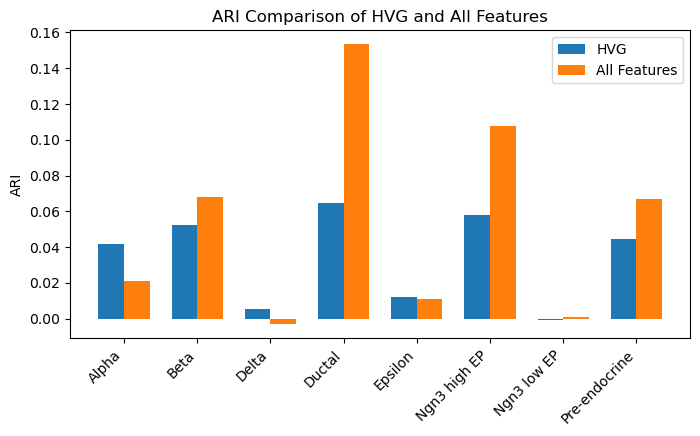

In [21]:
# Plot ARI comparison of HVG and all features

# assume HVG_performance and all_features_performance are pandas DataFrames
HVG_ari = HVG_performance['ARI'].tolist()
all_features_ari = all_features_performance['ARI'].tolist()

# set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# set up the x-axis labels and positions
labels = HVG_performance.index.tolist()
x = np.arange(len(labels))

# set up the bar widths and positions
width = 0.35
offset = width / 2

# plot the bars
rects1 = ax.bar(x - offset, HVG_ari, width, label='HVG')
rects2 = ax.bar(x + offset, all_features_ari, width, label='All Features')

# add labels and legend
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('ARI')
ax.set_title('ARI Comparison of HVG and All Features')
ax.legend()

# show the plot
plt.show()

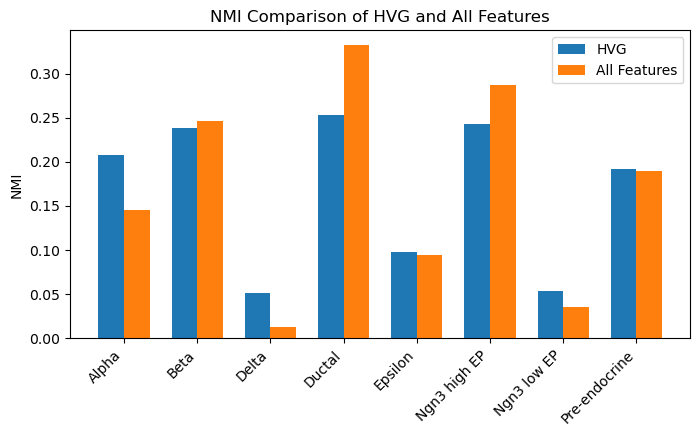

In [22]:
# Plot NMI comparison of HVG and all features
HVG_nmi = HVG_performance['NMI'].tolist()
all_features_nmi = all_features_performance['NMI'].tolist()

# set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
labels = HVG_performance.index.tolist()
x = np.arange(len(labels))

width = 0.35
offset = width / 2

rects1 = ax.bar(x - offset, HVG_nmi, width, label='HVG')
rects2 = ax.bar(x + offset, all_features_nmi, width, label='All Features')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('NMI')
ax.set_title('NMI Comparison of HVG and All Features')
ax.legend()
plt.show()